<a href="https://colab.research.google.com/github/ryanstwrt/osu-transport/blob/gh-pages/users/stewryan/Blackboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install osbrain

In [0]:
pip install sklearn-contrib-py-earth

In [0]:
pip install ace

In [0]:
import osbrain
from osbrain import run_nameserver
from osbrain import run_agent
from osbrain import Agent
import time
import tables as tb
import os
import numpy as np
import collections
from collections import OrderedDict
from random import random
from pyearth import Earth

# Introduction to Blackboard System

Blackboard systems are used to solve large multi-facited problems in a piece-wise incremental manor. The basic components to a blackboard system can be seen in the bulleted list below.

*   Blackboard: Specialized space for agents to write their solutions to a problem too. This is typically stored in memory for quick access, but can also be written to a file for later use. The blackboard can contain specialized infrastructures which ease the reading and writing process for large problems.
*   Controller Agent: Initiates the problem, tells other agents when to perform their actions, and when  their results can be added to the blackboard.
*   Knowledge Agents: Contain specialized expertise in a problem and contribute to solving the problem at large with their specific piece of knowledge. For a multi-physics problem, this could be solving a set of equations with different methods or solving different sets of equation.

Below is a basic blackboard system which involved three agents; a controller and two knowledge agents.
The blackboard is used to create a HDF5 file, which the agents will write too, and keep track of the progress of the agents.
The simple example has a controller and two agents (A and B) writing the square of values 0 to 9 to the database.
Neither agent wants to copy what the other is dointn so they perform a simple check to ensure they are producing unique data. 
If so, they write the square of the given value to the database.
Agent A is working in forward from 0 to 9, while Agent B is working in reverse. 
At the end, the database has 10 entries ranging from 0 to 9.

In [0]:
class Blackboard(object):
  """This class will be the blackboard from which knowledge agents write to and read from.
  The state variable keeps track of who is writting to the blackboard, and how many problems have been solved."""

  def __init__(self):
    self.agents = []
    self.state = {
        'problems': 0,
        'contributions': [],
    }
    #Set up the HDF5 databsase
    db = tb.open_file("blackboard_db", "w")
    db.close()

  def add_agent(self, agent):
    self.agents.append(agent)

class Controller(object):
  """Controls the flow of work distribution in the problem"""

  def __init__(self, blackboard):
    self.blackboard = blackboard

  def solve_problem(self):
    i = 0
    while self.blackboard.state['problems'] < 20:
      for agent in self.blackboard.agents:
        agent.contribute(i)
      i+=1        
    return self.blackboard.state['contributions']
  

class baseAgent(object):
  """Base agent to define __init__ and basic functions"""

  def __init__(self, blackboard, name):
    self.blackboard = blackboard
    self.name = name
    self.root = '/' + self.name
    db = tb.open_file("blackboard_db", "a")
    db.create_group(db.root, self.name)    
    db.close()

  def contribute(self, i):
    pass

  def squared(self, x):
    return x * x

class AgentA(baseAgent):
  """Agent A will count from 0 to 10"""

  def contribute(self, i):
    doubled = self.squared(i)
    with tb.open_file("blackboard_db", "a") as db:
      for node in db:
        if 'Val_{}'.format(str(i)) in node:
          self.blackboard.state['problems'] = 20
      else:
        db.create_array(self.root, 'Val_{}'.format(str(i)) , [doubled])
    self.blackboard.state['problems'] += 1
    self.blackboard.state['contributions'] += [self.__class__.__name__]

class AgentB(baseAgent):
  """Agent B will count in reverse from 10 to 0"""

  def contribute(self, i):
    i = 9 - i
    doubled = self.squared(i)
    with tb.open_file("blackboard_db", "a") as db:
      for node in db:
        if 'Val_{}'.format(str(i)) in node:
          self.blackboard.state['problems'] = 20
      else:
        db.create_array(self.root, 'Val_{}'.format(str(i)) , [doubled])
    self.blackboard.state['problems'] += 1
    self.blackboard.state['contributions'] += [self.__class__.__name__]

if __name__ == '__main__':
  os.system('rm blackboard_db')
  blackboard = Blackboard()
  blackboard.add_agent(AgentA(blackboard, 'AgentA'))
  blackboard.add_agent(AgentB(blackboard, 'AgentB'))
  c = Controller(blackboard)
  contributions = c.solve_problem()

  h5db = tb.open_file('blackboard_db', 'r+')
  print(h5db)
  h5db.close()

# Multi-Agent Systems

Multi-agent systems (MAS) focus on creating individual pieces of software (called agents) who perform some type of task independently of each other and of the user.
Agents can communicate with each other via messages to influence what the agents are working on.
A central theme for MAS is the autonomy of agents, where they can be designed to work cooperatively or competitively with other agents to accomplish goals.
The module [osBrain](https://osbrain.readthedocs.io/en/stable/) is used to create agents in the below examples and a view interactions methods are shown.
Some basic nomenclature is important to understand how MAS work in ```osBrain```.


*   Agent: Main entity which runs independently of other agents. Its major responsibilities are to poll for incomming messages, process the message, perform some type of action bas on the message, and repeat.
*   Proxy: Local objects which enables the user and other agents to access and communicate with a remote agent. Allows us to call methods or access attributes.



In [0]:
if __name__ == '__main__':
    # Create and server to house the multiple agents that will be created
    # This is where the agents will reside and how they can be communicated with
    ns = run_nameserver()
    #The run_agent() method creates a proxy to an agent on a remote server, where name='' allows users to create an alias for that proxy
    #Two methods to create an agent; the first creates an agent with no variables assigned to it, the second method creates a variable assiged proxy to an agent
    run_agent(name='Exp1')
    agent2 = run_agent(name='Exp2')

    #Create a proxy to agent Exp1 to easily access it
    agent1 = ns.proxy('Exp1')
    #Log a message via the proxy Exp1 agent
    agent1.log_info(' Hello World, I am tesing an agent')
    agent2.log_info('Hello, I am a second agent')

    #Determine what agents are alie in the server
    for alias in ns.agents():
      print(alias)
    #shutdown the server as it is no longer needed, otherwise the agents will continue to run
    ns.shutdown

# Multi-Agent Blackboard System (MABS)
## Base Classes
The following section defines our base classes for the multi-agent blackboard system.
To reduce the number of communication lines, the controller agent from the previous sections has been incorporated with the blackboard class.
The blackboard class will now act as both the repository for information obtained by the agents, and will determine if/when agents should perform their next action.

Along with this, the agents no longer inheret from ```object```, but instead inheret from ```Agent```. 
```Agent``` is the base class for osBrain which creates a remote object that performs work independently of other agents.
These classes are interacted with via a proxy class, which is seen in the ```__main__``` section, where ```ka_a``` is a proxy which allows us to interact with ```KA_A```.

In [0]:
def log_message(self, message):
  self.log_info('{}'.format(message))

class Blackboard(Agent):
  def on_init(self):
    #Create a connection for others to ask for permission to write to the HDF file
    self.bind('REP', alias='ask_permission', handler='ask_permission')
    self.bind('PUSH', alias='run_opt_A')
    self.bind('PUSH', alias='run_opt_B')
    self.open_to_write = True
    self.agents = []
    self.state = {
        'problems': 0,
        'contributions': [],
    }
    db = tb.open_file("blackboard_db", "w")
    db.close()

  def solve_problem(self):
    """Main loop to solve the problem at hand. First initialize the problem/agents
    Then agents will continually ask if addional runs are needed"""
    self.initialize()
    return self.state['contributions']

  def add_agent(self, agent):
    """Add an agent to the agent list and create line o fcommunication with it"""
    self.agents.append(agent)
    self.connect(agent.addr('run_next_opt'), alias='run_next_opt', handler='ready_agent')

  def ask_permission(self, agent_asking):
    #Surrogate for ask permission, will eventually include logic to ensure no other agent is accessing HDF

    if self.open_to_write:
      self.open_to_write = False
      log_message(self, 'Agent {} can write to BB'.format(agent_asking))
      self.state['problems'] += 1
      self.state['contributions'] += [agent_asking]
      return True
    else:
      log_message(self, 'Agent {} cannot write to BB'.format(agent_asking))
      return False    

  def initialize(self):
    for agent in self.agents:
      self.run_opt(agent, self.state['problems'])

  def ready_agent(self, agent):
    self.open_to_write = True
    if self.state['problems'] < 9:
      self.run_opt(agent, self.state['problems'])
    else:
      print('Shutting down')
      agent.shutdown()

  def run_opt(self, agent, i):
    name = agent.get_attr('name')
    if name == 'ka_a':
      self.send('run_opt_A', i)
    elif name == 'ka_b':
      self.send('run_opt_B', i)


class baseKA(Agent):
  """Base agent to define __init__ and basic functions"""

  def on_init(self):
    # This connects to the blackboard and is used to signal when the agent needs to write 
    # to the blackboard, this is a reply-requestion communication
    self.connect(self.bb_addr(self.bb_permission_alias), alias=self.bb_permission_alias)
    # This connects to the blackboard. When the blackboard sends the agent a message via the run_opt alias, 
    # it will trigger the simulate method as the handler to solve the problem
    self.connect(self.bb_addr(self.bb_opt_alias), alias=self.bb_opt_alias, handler='simulate')
    self.bind('PUSH', alias='run_next_opt')
    self.root = '/{}'.format(self.name)
    self.db_entry = []
    self.doubled = 0
    self.val = 0
    db = tb.open_file("blackboard_db", "a")
    db.create_group(db.root, self.name)
    db.close()

  def write_to_db(self):
    # Open the database and check if the result has already been submitted.
    # If it has, don't write to DB
    with tb.open_file("blackboard_db", "a") as db:
      for node in db:
        if 'Val_{}'.format(self.val) in node:
          break
      else:
        db.create_array(self.root, 'Val_{}'.format(self.val), [self.doubled])

  def ask_permission_to_write(self):
    """Create a loop and continually check to determine if we can write to the database"""
    can_send = False
    while can_send == False:
      #Ask BB if agent can write to BB
      self.send(self.bb_permission_alias, self.name)
      can_send = self.recv(self.bb_permission_alias)
      time.sleep(0.5)
    self.write_to_db()

  def simulate(self, i):
    pass

  def squared(self, x):
    self.val = x
    return x * x

  def ask_bb(self):
    """Let the Blackboard know the agent is ready to solve another problem"""
    self.send('run_next_opt', self)    

In [0]:
 class KA_A(baseKA):

  def simulate(self, i):
    self.doubled = self.squared(i)
    time.sleep(1)
    self.ask_permission_to_write()
    self.ask_bb()

 class KA_B(baseKA):

  def simulate(self, i):
    self.doubled = self.squared(i)
    time.sleep(1)
    self.ask_permission_to_write()
    self.ask_bb()    

if __name__ == '__main__':
  os.system('rm blackboard_db')
  ns = run_nameserver()
  bb = run_agent(name='blackboard', base=Blackboard)
  ka_a = run_agent(name='ka_a', base=KA_A, attributes={'bb_addr':bb.addr,
                                                       'bb_permission_alias':'ask_permission',
                                                       'bb_opt_alias':'run_opt_A'})
  ka_b = run_agent(name='ka_b', base=KA_B, attributes={'bb_addr':bb.addr,
                                                       'bb_permission_alias':'ask_permission',
                                                       'bb_opt_alias':'run_opt_B'})  
  bb.add_agent(ka_a)
  bb.add_agent(ka_b)
  contributions = bb.solve_problem()

  #Let the agent continue to run until only the blackboard agent is left.
  while len(ns.agents()) > 1:
    time.sleep(5)
  else:
    h5db = tb.open_file('blackboard_db', 'r+')
    print(h5db)
    h5db.close()
    ns.shutdown()

Broadcast server running on 0.0.0.0:9091
NS running on 127.0.0.1:18656 (127.0.0.1)
URI = PYRO:Pyro.NameServer@127.0.0.1:18656
INFO [2019-11-13 20:17:58.907690] (blackboard): Agent ka_a can write to BB
INFO [2019-11-13 20:17:58.910846] (blackboard): Agent ka_b cannot write to BB
INFO [2019-11-13 20:17:59.416119] (blackboard): Agent ka_b cannot write to BB
INFO [2019-11-13 20:17:59.920627] (blackboard): Agent ka_b can write to BB
INFO [2019-11-13 20:18:00.426330] (blackboard): Agent ka_a cannot write to BB
INFO [2019-11-13 20:18:00.930736] (blackboard): Agent ka_a can write to BB
INFO [2019-11-13 20:18:01.432531] (blackboard): Agent ka_b cannot write to BB
INFO [2019-11-13 20:18:01.937761] (blackboard): Agent ka_b can write to BB
INFO [2019-11-13 20:18:02.444451] (blackboard): Agent ka_a cannot write to BB
INFO [2019-11-13 20:18:02.948057] (blackboard): Agent ka_a can write to BB
INFO [2019-11-13 20:18:03.458273] (blackboard): Agent ka_b can write to BB
INFO [2019-11-13 20:18:04.459379] 

## Model-based Reflex Agent

This examines a class of agents known as model-based reflex agents.
In general these agents recieve a stimulus from the environment (aka the blackboard),
examine their previous actions, and perform an action based on this.

each ```percept``` should countiain if the previous state failed

each ```state``` will contain a triple tuple in the form:
(current opt scheme, action taken, success of action)

Note, that the scheme and action taken are placed in the state before the action is taken. 
We only find out if the action was a success when the simulation is run and we use the sensor on the environment again 

```current_state``` will be true or false depending on if the simulation succeeded or failed (given as the ```percept``` from the environment

In [0]:
class mbra(object):
  def __init__(self):
    self.state = OrderedDict()
    self.action_list = {'new': 1.0, 'validate': 0.0}
    self.action_success = True
    self.action = 'new'
    self.optimization_num = [0,0,0]
    self.previous_state_key = 0
    self.failed_validation = 0
  
  def sensor(self, percept):
    self.action_success = percept
    self.update_state()
    self.update_actions()
    self.take_action()

  def update_state(self):
    self.state[self.previous_state_key] = (self.optimization_num, self.action, self.action_success)
  
  def update_actions(self):
    """Update actions probabilities based on if the action was new or a validation and if the action was successful or failed
       If we fail a validation, we force the validation probability to 100% to explore additional validation """
    state, action, success = self.state[self.previous_state_key]
    if action == 'new':
        self.action_list['validate'] += self.action_list['new'] * 0.01
        self.action_list['new'] -= self.action_list['new'] * 0.01
    elif action == 'validate':
      #If an old event fails, that means our assumption is failing, run another old event. 
      #If it succeeds, slowly increase the probability of running a new one.
      if success:
        self.action_list['new'] += self.action_list['validate'] / 4
        self.action_list['validate'] -= self.action_list['validate'] / 4
      else:
        self.failed_validation += 1
        if failed_validation > 10:
          print('Error: Basic assumption is faulty, update scheme.')
        else:
          print('Warning: Failed a validation check. Underlying assumption may be faulty.')
          self.action_list['new'] = 0.0
          self.action_list['validate'] = 1.0
    else:
      print('did not update action list due to unknown action: {}'.format(action))

  def take_action(self):
    """Determine which action to take based on the probability for each action"""
    action_val = random()
    self.previous_state_key += 1
    if action_val < self.action_list['new']:
      self.action = self.run_new_simulation()
    else:
      self.action = self.run_validation_simulation()
  
  def run_new_simulation(self):
    return 'new'

  def run_validation_simulation(self):
    return 'validate'

if __name__ == '__main__':
  test_agent = mbra()
  for success in [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,
                  True, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True]:
    test_agent.sensor(True)
  print(test_agent.action_list)
  for k,v in test_agent.state.items():
    print(k,v)

{'new': 0.7995655945002865, 'validate': 0.2004344054997135}
0 ([0, 0, 0], 'new', True)
1 ([0, 0, 0], 'new', True)
2 ([0, 0, 0], 'new', True)
3 ([0, 0, 0], 'new', True)
4 ([0, 0, 0], 'new', True)
5 ([0, 0, 0], 'new', True)
6 ([0, 0, 0], 'new', True)
7 ([0, 0, 0], 'new', True)
8 ([0, 0, 0], 'new', True)
9 ([0, 0, 0], 'new', True)
10 ([0, 0, 0], 'new', True)
11 ([0, 0, 0], 'validate', True)
12 ([0, 0, 0], 'new', True)
13 ([0, 0, 0], 'new', True)
14 ([0, 0, 0], 'validate', True)
15 ([0, 0, 0], 'new', True)
16 ([0, 0, 0], 'new', True)
17 ([0, 0, 0], 'new', True)
18 ([0, 0, 0], 'new', True)
19 ([0, 0, 0], 'new', True)
20 ([0, 0, 0], 'new', True)
21 ([0, 0, 0], 'new', True)
22 ([0, 0, 0], 'new', True)
23 ([0, 0, 0], 'new', True)
24 ([0, 0, 0], 'new', True)
25 ([0, 0, 0], 'new', True)
26 ([0, 0, 0], 'new', True)
27 ([0, 0, 0], 'validate', True)
28 ([0, 0, 0], 'new', True)
29 ([0, 0, 0], 'new', True)
30 ([0, 0, 0], 'new', True)
31 ([0, 0, 0], 'new', True)
32 ([0, 0, 0], 'new', True)
33 ([0, 0, 

[[ 0  0  0]
 [ 1  2  3]
 [ 2  4  6]
 [ 3  6  9]
 [ 4  8 12]]
[-4.26068664 -3.40854931 -2.55641198  0.93735106]
[-4.75323154 -3.80258523 -2.85193892  1.04571094]
[-4.75323154 -3.80258523 -2.85193892  1.04571094]


/usr/local/lib/python3.6/dist-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.6/dist-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


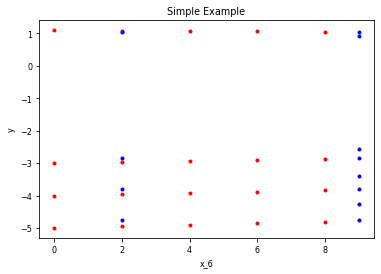

In [156]:
from matplotlib import pyplot

#Create some fake data
np.random.seed(0)
x_1 = [0, 0, 0] # This would be one set of data, for example number of experiments fo A,B, and C
x_2 = [1, 2, 3] # This woudl be another set of data
X = [x_1,x_2]
for i in range(3):
  X.append([(i+2) * x for x in x_2]) # More generated data

X = np.array(X)
y = [[-5, -4, -3, 1.1]] #Set of dependent variables associated with X_1
for i in range(4):
  y.append([(0.99) * y for y in y[i]]) #set of depended variables associated with x_2, 3 et.c

print(X)

#Fit an Earth model
model = Earth()
X_2 = np.array([[15, 9, 12], [5,2,22], [5,9,12]])
model.fit(X,y)

#Print the model
#print(model.trace())
#print(model.summary())

#Plot the model
y_hat = model.predict(X_2)
for val in y_hat:
  print(val)
pyplot.figure()
pyplot.plot(X[:,1],y,'r.')
pyplot.plot(X_2[:,1],y_hat,'b.')
pyplot.xlabel('x_6')
pyplot.ylabel('y')
pyplot.title('Simple Example')
pyplot.show()


* Starting outer iteration 000. Current err =  1.00000E+00
  Starting inner iteration 000. Current err =  1.00000E+00
  Starting inner iteration 001. Current err =  9.03464E-02
  Starting inner iteration 002. Current err =  3.02272E-02
  Starting inner iteration 003. Current err =  2.78704E-02
  Starting inner iteration 004. Current err =  2.38510E-02
  Starting inner iteration 005. Current err =  2.18417E-02
  Starting inner iteration 006. Current err =  2.16138E-02
  Starting inner iteration 007. Current err =  2.15561E-02
  Starting inner iteration 008. Current err =  2.15378E-02
  Starting inner iteration 009. Current err =  2.15176E-02
  Starting inner iteration 010. Current err =  2.13937E-02
  Starting inner iteration 011. Current err =  2.13751E-02
  Starting inner iteration 012. Current err =  2.12788E-02
  Starting inner iteration 013. Current err =  2.11932E-02
  Starting inner iteration 014. Current err =  2.10936E-02
  Starting inner iteration 015. Current err =  2.10686E-

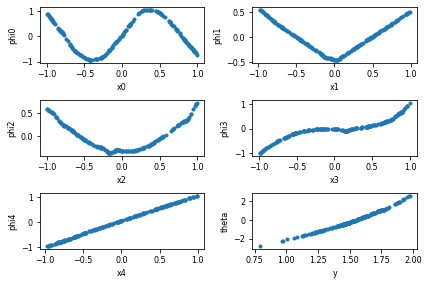

In [61]:
from ace.samples import wang04
x, y = wang04.build_sample_ace_problem_wang04(N=200)
from ace import model
myace = model.Model()
myace.build_model_from_xy(x, y)
myace.eval([0.1, 0.2, 0.5, 0.3, 0.5])
from ace import ace
ace.plot_transforms(myace.ace, fname = 'mytransforms.pdf')
myace.ace.write_transforms_to_file(fname = 'mytransforms.txt')

Investigate predictor (extrapolation) methods for determining where to run simulations. We can then continually update the method with new data points.
Note: This should be done for a single variable. i.e. if we have 3 ABR, 3 fertile, and 3 materials test and we are optimizing for materials tests then only add assemblies of the materials test type.

1. Run the simulation for two problems
2. Utilize a linear interpolation to find the point where we will violate a limit.
3. Select a point which is halfway to that point, and run a simulation.
4. Determine if a lienar regression holds true for this fit.
  a. If it does hold true, find a the point at which we violate a limit.
  b. If it does not hold true, increase to a higher polynomial formula and select a point based on this.
5. Run the simulation for the current point. Repeat 3. - 5. until we reach the limiting problem.

Alternativley we could use the following approach
1. Run the simulation for two problems
2. Check the blackboard and determine how many solutions are present.
  1. If enough solutions are present, implement a MARS/ACE regression to determine violation point
  2. If not, utilize a linear interpolation for each of the objectives to find the point where we violate a limit.
3. Select a a point below this value and run the simulation, repeat steps 2. - 3. until you find optimal point


ACE might be beneficial to use in the final analysis of rthe dataset, where MARS might be better for the actual interpolation/extrapolation